DownSampling_180

DropOut True

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt

df = pd.read_csv('../Preprocessing/data_downsampling_180.csv', header=None)
df_y = pd.read_csv('../Preprocessing/data_output.csv', header=None)

X = df.values
y = df_y.iloc[:, 0].values

# 레이블을 숫자로 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 레이블을 One-Hot Encoding
y_onehot = to_categorical(y_encoded, num_classes=5)

# 훈련/검증 데이터로 분리
X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_val = X_val.reshape(-1, X_val.shape[1], 1)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 178, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 89, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 87, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 43, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 2752)              0         
                                                                 
 dense (Dense)               (None, 128)               3

In [5]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
2738/2738 [==============================] - 16s 6ms/step - loss: 0.2106 - accuracy: 0.9452 - val_loss: 0.0970 - val_accuracy: 0.9756
Epoch 2/20
2738/2738 [==============================] - 11s 4ms/step - loss: 0.1065 - accuracy: 0.9716 - val_loss: 0.0754 - val_accuracy: 0.9799
Epoch 3/20
2738/2738 [==============================] - 11s 4ms/step - loss: 0.0847 - accuracy: 0.9775 - val_loss: 0.0715 - val_accuracy: 0.9813
Epoch 4/20
2738/2738 [==============================] - 11s 4ms/step - loss: 0.0748 - accuracy: 0.9795 - val_loss: 0.0537 - val_accuracy: 0.9864
Epoch 5/20
2738/2738 [==============================] - 11s 4ms/step - loss: 0.0656 - accuracy: 0.9823 - val_loss: 0.0504 - val_accuracy: 0.9884
Epoch 6/20
2738/2738 [==============================] - 11s 4ms/step - loss: 0.0603 - accuracy: 0.9830 - val_loss: 0.0485 - val_accuracy: 0.9883
Epoch 7/20
2738/2738 [==============================] - 12s 4ms/step - loss: 0.0548 - accuracy: 0.9846 - val_loss: 0.0446 - val_ac

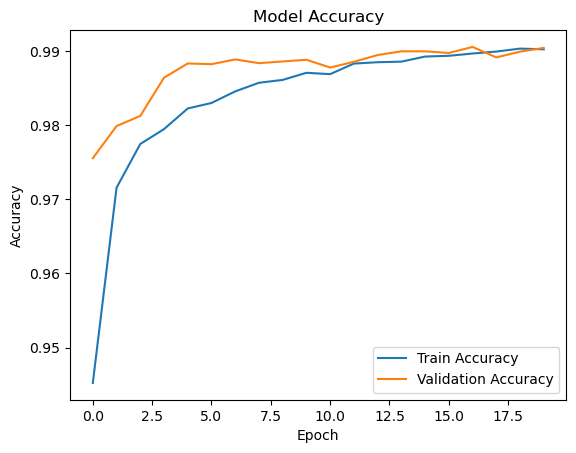

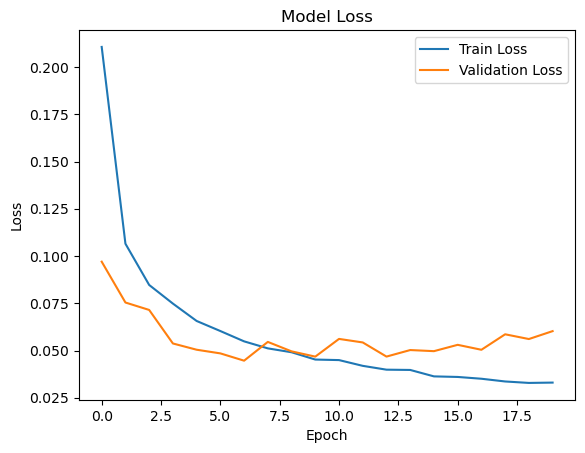

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# 검증 데이터셋에 대한 예측 수행
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측된 클래스 인덱스
y_true_classes = np.argmax(y_val, axis=1)  

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

685/685 [==============================] - 1s 2ms/step


TP (True Positive): 해당 클래스로 올바르게 예측된 샘플 수
TN (True Negative): 해당 클래스와 관련이 없는 샘플이 올바르게 예측된 수
FP (False Positive): 해당 클래스가 아닌 샘플을 해당 클래스로 잘못 예측한 수
FN (False Negative): 해당 클래스를 다른 클래스로 잘못 예측한 수
Accuracy: 각 클래스별로 올바르게 예측된 샘플의 비율

전체 클래스의 영향을 반영한 정확도
(TP + TN) / (TP + TN + FP + FN)

In [18]:
def calculate_tptnfpfn(conf_matrix, class_index):
    TP = conf_matrix[class_index, class_index]
    FN = conf_matrix[class_index, :].sum() - TP
    FP = conf_matrix[:, class_index].sum() - TP
    TN = conf_matrix.sum() - (TP + FN + FP)
    return TP, TN, FP, FN

metrics = []

for i in range(len(conf_matrix)):
    TP, TN, FP, FN = calculate_tptnfpfn(conf_matrix, i)
    metrics.append({
        'Class': label_encoder.classes_[i],
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'Accuracy': (TP + TN) / (TP + TN + FP + FN)
    })

metrics_df = pd.DataFrame(metrics)

print(metrics_df)


  Class     TP     TN   FP  FN  Accuracy
0     F    107  21749    8  35  0.998036
1     N  18104   3613  139  43  0.991689
2     Q   1595  20278    9  17  0.998813
3     S    460  21342   23  74  0.995571
4     V   1424  20405   30  40  0.996804


각 개별 클래스의 정확도 TP/ (TP + FN)

In [19]:
# 각 클래스별 정확도 계산
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

import pandas as pd

class_labels = label_encoder.classes_ 
accuracy_df = pd.DataFrame({
    'Class': class_labels,
    'Accuracy': class_accuracy
})

print(accuracy_df)


  Class  Accuracy
0     F  0.753521
1     N  0.997630
2     Q  0.989454
3     S  0.861423
4     V  0.972678


In [20]:
from sklearn.metrics import accuracy_score

# 전체 정확도 계산
overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Overall Accuracy: {overall_accuracy:.4f}')


Overall Accuracy: 0.9905
